# Conditional Bernoulli Project

In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import Counter
from itertools import combinations
from scipy.stats import qmc

import matplotlib.pyplot as plt

## I-Rejection Sampling


### Exploring the Impact of Sample Size, k Value, and Sample Variance on Acceptance Rate

In this section, we will experiment with varying the sample size, the target sum (`k` value), and the variance of the sample probabilities. Our goal is to observe how these factors influence the acceptance rate of the rejection sampling algorithm. By analyzing these relationships, we aim to gain insights into the behavior and efficiency of the sampling process under different conditions.


### Rejection sampler definition and acceptance for different sizes/k

In [17]:

def rejection_sampler(p, k, n_samples=1000):
    
    """
    Generate samples from Bernoulli distributions conditioned on their sum being k.

    Parameters:
    - p: Probabilities for each Bernoulli variable.
    - k: Desired sum.
    - n_samples: Number of samples to generate.

    Returns:
    - accepted_samples: Array of valid samples.
    - attempts: Total number of attempts.
    """
    p = np.array(p)
    N = len(p)
    accepted_samples = []
    attempts = 0

    while len(accepted_samples) < n_samples:
        # Generate a sample of N independent Bernoulli random variables
        sample = np.random.rand(N) < p
        attempts += 1
        # Check if the sum equals k
        if sample.sum() == k:
            accepted_samples.append(sample)
    
    return np.array(accepted_samples), attempts




In [18]:
# Dictionary to store acceptance rates for each size, k, and repetition
acceptance_rates_repeated = {}

# Repeat the process 10 times
n_repeats = 10
for rep in tqdm(range(n_repeats)):
    for size in [10, 50, 100, 500, 1000]:  # Array sizes to test
        p = np.random.rand(size)
        if size not in acceptance_rates_repeated:
            acceptance_rates_repeated[size] = {}
        exp = np.sum(p)  # Calculate the expected sum of the Bernoulli variables
        
        k_min = int(max(1, exp - len(p) / 20))  # Lower bound for k
        k_max = int(min(exp + len(p) / 20, size))  # Upper bound for k
        for k in range(k_min, k_max + 1):
            # Use a single sample for large arrays to avoid memory issues
            n_samples = 10 if size >= 500 else 100
            samples, attempts = rejection_sampler(p, k, n_samples=n_samples)
            acceptance_rate = samples.shape[0] / attempts
            if k not in acceptance_rates_repeated[size]:
                acceptance_rates_repeated[size][k] = []
            acceptance_rates_repeated[size][k].append(acceptance_rate)



100%|██████████| 10/10 [05:10<00:00, 31.10s/it]


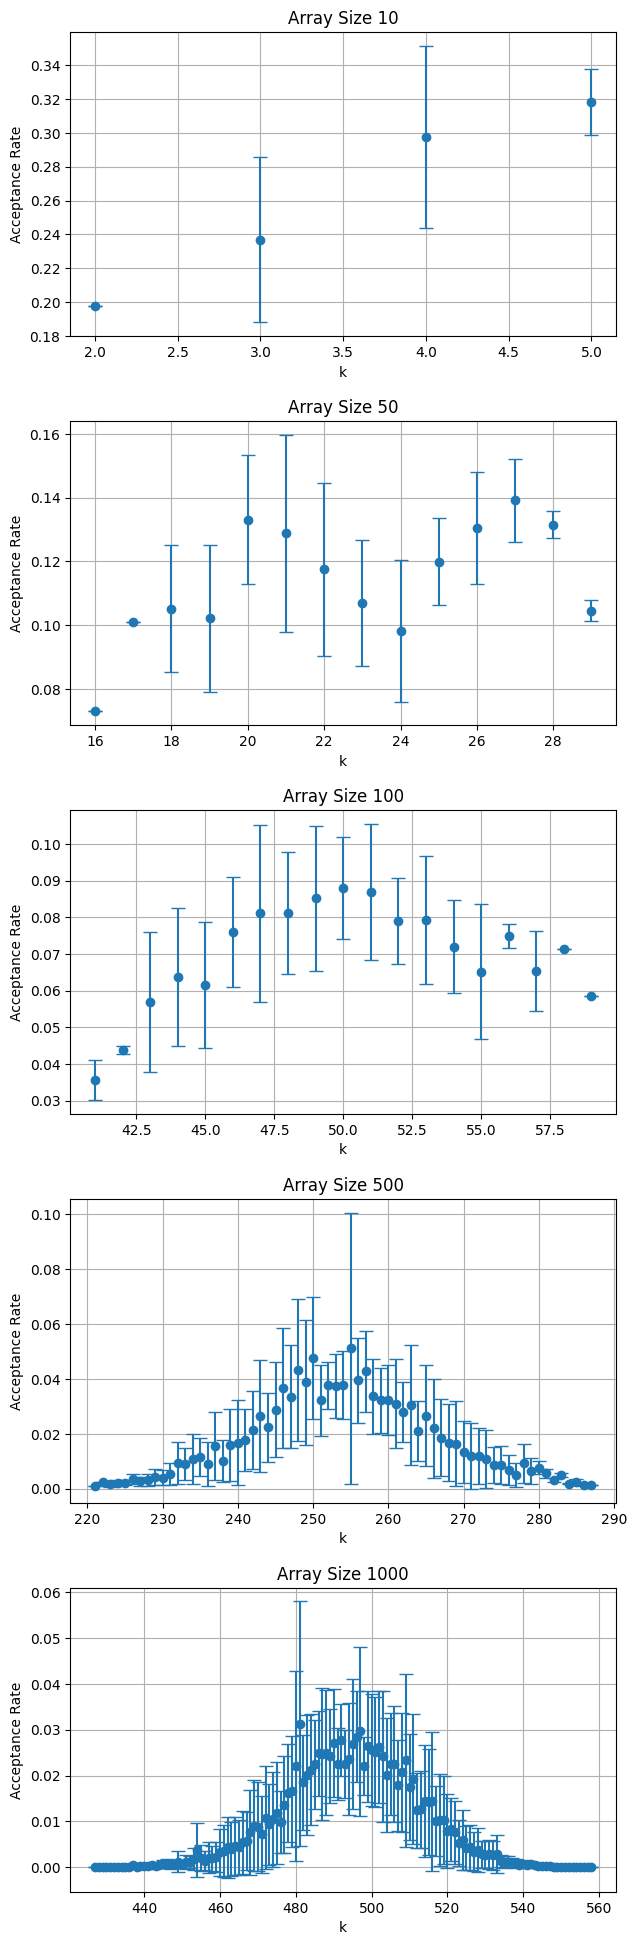

In [19]:
# Plot the error bars
fig, axes = plt.subplots(nrows=len(acceptance_rates_repeated), ncols=1, figsize=(7, 20))
fig.tight_layout(pad=4.0)

for ax, (size, k_dict) in zip(axes, acceptance_rates_repeated.items()):
    # Calculate the mean and standard deviation of the acceptance rates
    k_values = list(k_dict.keys())
    rates_mean = [np.mean(k_dict[k]) for k in k_values]
    rates_std = [np.std(k_dict[k]) for k in k_values]
    
    # Plot the error bars without label
    ax.errorbar(k_values, rates_mean, yerr=rates_std, fmt='o', capsize=5)
    
    ax.set_xlabel('k')
    ax.set_ylabel('Acceptance Rate')
    ax.set_title(f'Array Size {size}')
    ax.grid(True)

plt.show()


### As $N \to \infty$

As the number of Bernoulli trials $N$ approaches infinity, the probability $P(S = k)$, where $S$ is the sum of the Bernoulli random variables, appears to converge towards a normal distribution.


### Acceptance rate for varying variances

In [20]:
acceptance_rates_variance = {}

for size in [10, 100, 1000, 10000]:
    print(f"Size: {size}")
    random_arrays = [np.random.rand(size) for _ in range(5000)]
    variances = [np.var(arr) for arr in random_arrays]

    # Sort arrays by variance and extract
    sorted_indices = np.argsort(variances)[::(len(variances)) // 50]
    sorted_arrays = [random_arrays[i] for i in sorted_indices]

    # Calculate acceptance rates for each array
    acceptance_rates_variance[size] = {}
    for arr in tqdm(sorted_arrays):
        samples, attempts = rejection_sampler(arr, int(np.sum(arr)), n_samples=100)
        acceptance_rate = samples.shape[0] / attempts
        acceptance_rates_variance[size][np.var(arr)] = acceptance_rate





Size: 10


100%|██████████| 50/50 [00:00<00:00, 1099.53it/s]


Size: 100


100%|██████████| 50/50 [00:00<00:00, 395.63it/s]


Size: 1000


100%|██████████| 50/50 [00:01<00:00, 49.42it/s]


Size: 10000


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


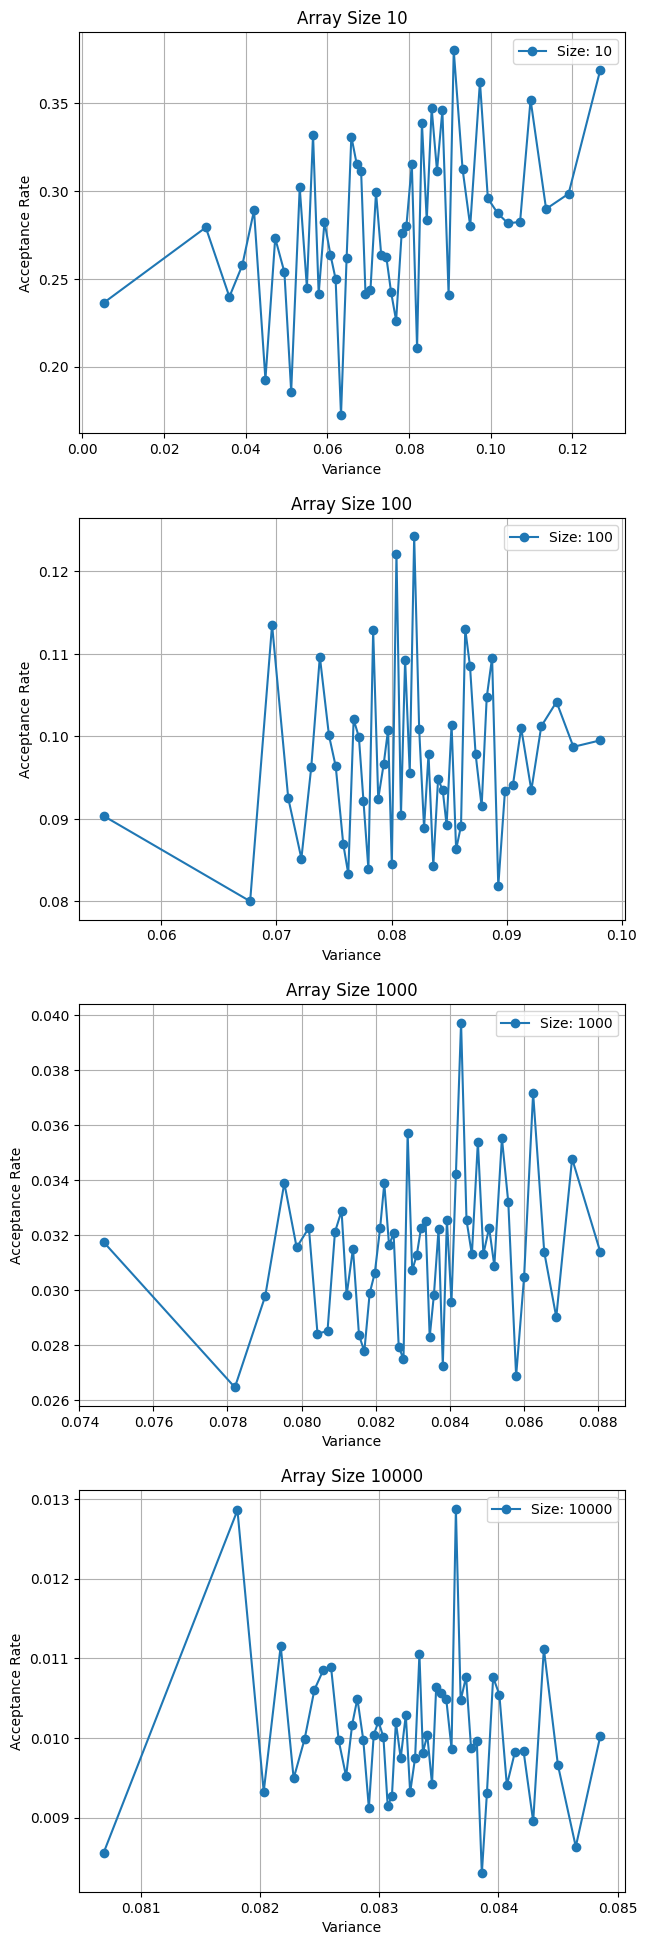

In [21]:

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=len(acceptance_rates_variance), ncols=1, figsize=(7, 20))
fig.tight_layout(pad=4.0)

# Iterate over the sizes and their corresponding variance dictionaries
for ax, (size, variance_dict) in zip(axes, acceptance_rates_variance.items()):
    variance_values = list(variance_dict.keys())
    rates = list(variance_dict.values())
    
    ax.plot(variance_values, rates, marker='o', label=f'Size: {size}')
    ax.set_xlabel('Variance')
    ax.set_ylabel('Acceptance Rate')
    ax.set_title(f'Array Size {size}')
    ax.legend()
    ax.grid(True)

plt.show()


From the analysis, it appears that the variance of the sample probabilities does not significantly impact the acceptance rate of the rejection sampling algorithm. This suggests that the acceptance rate is primarily influenced by other factors, such as the target sum (`k`) and the size of the sample, rather than the variance of the probabilities within the sample.


## II-Dynamic programming algorithm approach


The implementation provided here corresponds to the algorithm described in Appendix A of the paper [Heng, Jacob, and Ju (2020)](https://arxiv.org/pdf/2012.03103). To test its validity we then compare the empirical distribution of the obtained samples with the empirical distribution computed using a rejection sampler.

100%|██████████| 100/100 [00:24<00:00,  4.10it/s]
/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/3648371330.py:105: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_data_melted, x='Vector', y='Proportion', hue='Method', ci=None)


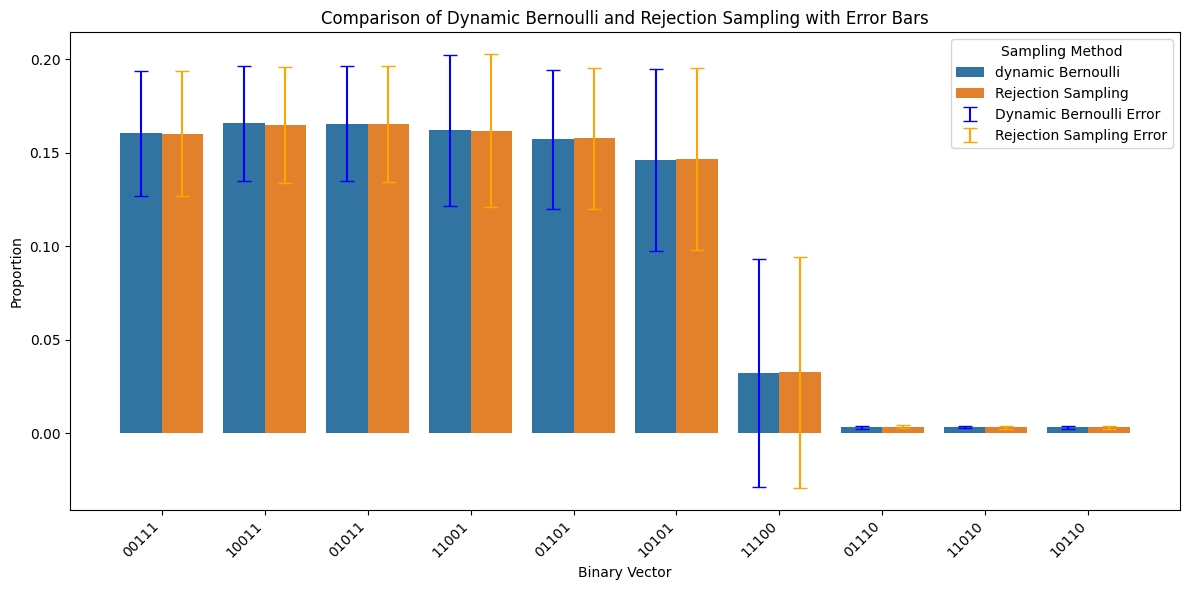

In [22]:
def sample_dynamic_bernoulli(p, I):
    """
    Samples from independent Bernoulli(p_i) variables conditioned on sum == I
    using the exact algorithm from Appendix A of Heng, Jacob, and Ju (2020).

    Parameters:
    - p: array-like of length N with values in (0,1)
    - I: integer, target sum of the Bernoulli vector

    Returns:
    - x: binary numpy array of length N such that sum(x) == I
    """
    p = np.asarray(p)
    N = len(p)

    # Initialize q table: q[i][n] = P(sum_{m=n}^N X_m = i)
    q = np.zeros((I + 2, N + 2))  # extra row and column for indexing convenience
    q[0, N + 1] = 1.0  # q(0, N+1) = 1

    # Step 1: compute q(0, n) recursively
    for n in range(N, 0, -1):
        q[0, n] = (1 - p[n - 1]) * q[0, n + 1]

    # Step 2: recursive computation for i = 1 to I
    for i in range(1, I + 1):
        q[i, N + 1] = 0.0  # initialize base case
        for n in range(N, 0, -1):
            q[i, n] = (1 - p[n - 1]) * q[i, n + 1]
            if i - 1 >= 0:
                q[i, n] += p[n - 1] * q[i - 1, n + 1]

    # Step 3: sample x sequentially
    x = np.zeros(N, dtype=int)
    remaining = I
    for n in range(1, N + 1):
        if remaining == 0:
            break  # fill the rest with zeros
        denom = q[remaining, n]
        if denom == 0:
            continue  # numerical safeguard
        num = p[n - 1] * q[remaining - 1, n + 1]
        r = num / denom
        x_n = np.random.rand() < r
        x[n - 1] = x_n
        if x_n:
            remaining -= 1

    return x





p_fixed = np.random.rand(5)
k_fixed = 3


# Run the sampling process 10 times to compute numerical error
dynamic_y_normalized_runs = []
rejection_y_normalized_runs = []

for _ in tqdm(range(100)):
    # Generate 10000 samples using dynamic Bernoulli
    dynamic_samples = [tuple(sample_dynamic_bernoulli(p_fixed, k_fixed)) for _ in range(10000)]
    dynamic_counts = Counter(dynamic_samples)

    # Generate 10000 samples using rejection sampling
    rejection_samples, _ = rejection_sampler(p_fixed, k_fixed, n_samples=10000)
    rejection_samples = [tuple(sample) for sample in rejection_samples]
    rejection_counts = Counter(rejection_samples)

    # Extract unique samples and their counts for both methods
    dynamic_y = list(dynamic_counts.values())
    rejection_y = [rejection_counts.get(sample, 0) for sample in dynamic_counts.keys()]

    # Normalize the counts for both methods
    dynamic_y_normalized = [count / sum(dynamic_y) for count in dynamic_y]
    rejection_y_normalized = [count / sum(rejection_y) for count in rejection_y]

    # Store normalized counts for error computation
    dynamic_y_normalized_runs.append(dynamic_y_normalized)
    rejection_y_normalized_runs.append(rejection_y_normalized)

    

# Compute mean and standard deviation for y-values
dynamic_y_mean = np.mean(dynamic_y_normalized_runs, axis=0)
dynamic_y_std = np.std(dynamic_y_normalized_runs, axis=0)
rejection_y_mean = np.mean(rejection_y_normalized_runs, axis=0)
rejection_y_std = np.std(rejection_y_normalized_runs, axis=0)

# Prepare data for plotting
dynamic_x = list(dynamic_counts.keys())
plot_data = pd.DataFrame({
    'Vector': [''.join(map(str, map(int, vec))) for vec in dynamic_x],
    'dynamic Bernoulli': dynamic_y_mean,
    'Rejection Sampling': rejection_y_mean
})

# Melt the data for seaborn compatibility
plot_data_melted = plot_data.melt(id_vars='Vector', var_name='Method', value_name='Proportion')

# Plot the proportions using seaborn with error bars
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_data_melted, x='Vector', y='Proportion', hue='Method', ci=None)

# Add error bars
x_positions = np.arange(len(dynamic_x))
plt.errorbar(x_positions - 0.2, dynamic_y_mean, yerr=dynamic_y_std, fmt='none', capsize=5, color='blue', label='Dynamic Bernoulli Error')
plt.errorbar(x_positions + 0.2, rejection_y_mean, yerr=rejection_y_std, fmt='none', capsize=5, color='orange', label='Rejection Sampling Error')

plt.xticks(ticks=x_positions, labels=[''.join(map(str, map(int, vec))) for vec in dynamic_x], rotation=45, ha='right')
plt.xlabel('Binary Vector')
plt.ylabel('Proportion')
plt.title('Comparison of Dynamic Bernoulli and Rejection Sampling with Error Bars')
plt.legend(title='Sampling Method')
plt.tight_layout()
plt.show()


The empirical distributions obtained using the Conditional Bernoulli sampling method and the Rejection Sampling method match each other closely. This shows that the conditional Bernoulli sampling method effectively samples according to the theoretical target distribution



## III- MCMC Algorithm for Conditional Bernoulli Sampling

This is an implementation of the MCMC algorithm presented at the start of https://arxiv.org/pdf/2012.03103, and we compare the obtained vector distribution with the target distribution for a fixed size p vector

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/1187065629.py:93: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df_plot_fixed_x, x='Vector', y='Proportion', hue='Steps', ci=None)


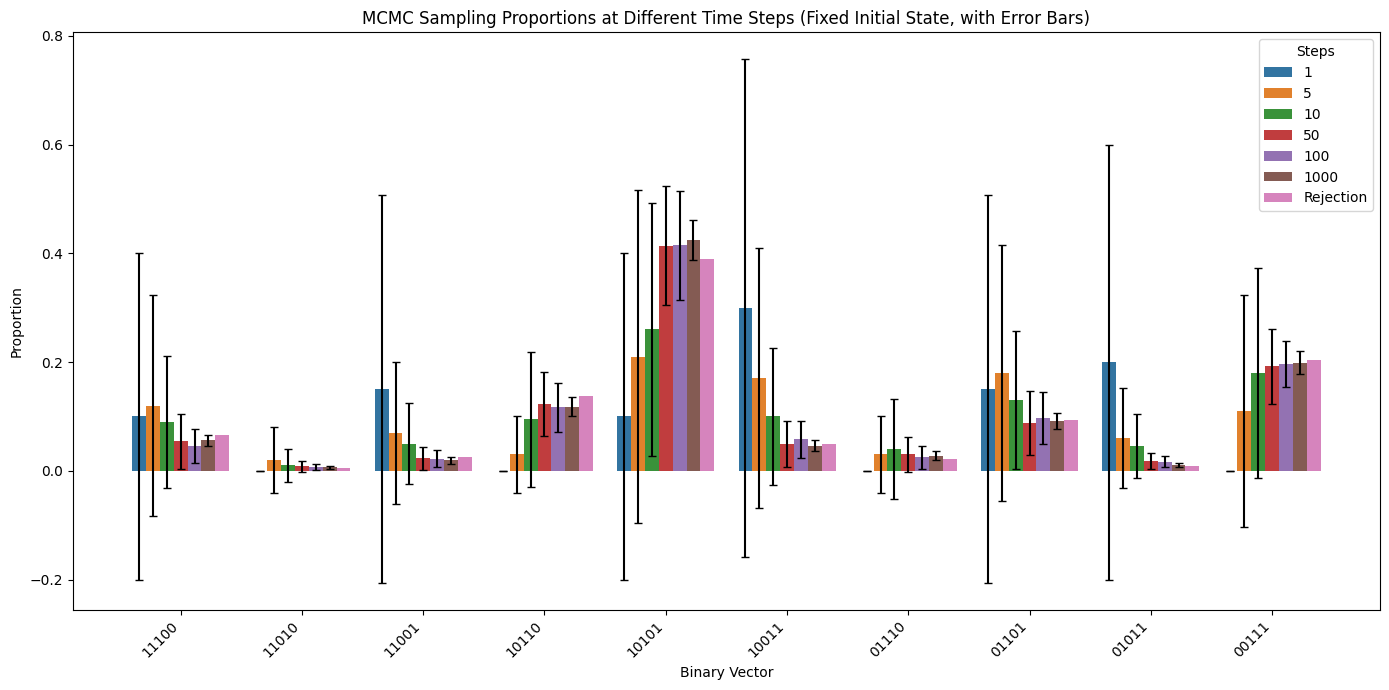

In [23]:

# MCMC step
def mcmc_step(x, w):
    ones = np.where(x == 1)[0]
    zeros = np.where(x == 0)[0]
    i1 = np.random.choice(ones)
    i0 = np.random.choice(zeros)
    alpha = min(1, w[i0] / w[i1])
    if np.random.rand() < alpha:
        x[i0], x[i1] = 1, 0
    return x


# Define p and k
p_fixed = np.random.rand(5)
k_fixed = 3
w = p_fixed / (1 - p_fixed)

# Define support (all binary vectors of length 5 with exactly 3 ones)
support = [tuple(int(i in c) for i in range(5)) for c in combinations(range(5), k_fixed)]

# Run comparison at step sizes: 10, 100, 1000
step_sizes = [1, 5, 10,50,100,1000]
results = {}
# Final fast version: only 1000 samples per setting
samples_per_setting = 1000
results_fastest = {}

initial_x = np.zeros(len(p_fixed), dtype=int)
initial_x[np.random.choice(len(p_fixed), k_fixed, replace=False)] = 1

# Generate rejection baseline
rejection_samples, _ = rejection_sampler(p_fixed, k_fixed, n_samples=samples_per_setting)
counts = Counter([tuple(s) for s in rejection_samples])
rejection_mean = [counts.get(vec, 0) / samples_per_setting for vec in support]







# Initialize a counter to accumulate sample frequencies
sample_counter = Counter()

# Prepare dictionary to store proportions at each step size# Reset the result storage
step_results_fixed_x = {step: [] for step in step_sizes}

n_runs=20
samples_per_run = 1000

# Run multiple chains starting from the same fixed initial state
for _ in range(n_runs):
    x = initial_x.copy()
    sample_counter = Counter()
    for step in range(1, samples_per_run + 1):
        x = mcmc_step(x, w)
        sample_counter[tuple(x)] += 1
        if step in step_sizes:
            total = sum(sample_counter.values())
            proportions = [sample_counter.get(vec, 0) / total for vec in support]
            step_results_fixed_x[step].append(proportions)

# Compute mean and std for each step size (with fixed initial x)
plot_data_fixed_x = []
for i, vec in enumerate(support):
    vec_str = ''.join(map(str, vec))
    for step in step_sizes:
        proportions = [run[i] for run in step_results_fixed_x[step]]
        mean = np.mean(proportions)
        std = np.std(proportions)
        plot_data_fixed_x.append({
            'Vector': vec_str,
            'Steps': str(step),
            'Proportion': mean,
            'Std': std
        })

# Add rejection sampling distribution (still no error bars here)
for i, vec in enumerate(support):
    vec_str = ''.join(map(str, vec))
    plot_data_fixed_x.append({
        'Vector': vec_str,
        'Steps': 'Rejection',
        'Proportion': rejection_mean[i],
        'Std': 0
    })

# Convert to DataFrame
df_plot_fixed_x = pd.DataFrame(plot_data_fixed_x)

# Plot with error bars
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df_plot_fixed_x, x='Vector', y='Proportion', hue='Steps', ci=None)

# Add error bars manually
step_labels = df_plot_fixed_x['Steps'].unique()
x_coords = np.arange(len(support))
bar_width = 0.8 / len(step_labels)

for j, step in enumerate(step_labels):
    if step == 'Rejection':
        continue  # No error bars for rejection sampling
    subset = df_plot_fixed_x[df_plot_fixed_x['Steps'] == step]
    offsets = x_coords - 0.4 + bar_width / 2 + j * bar_width
    plt.errorbar(offsets, subset['Proportion'], yerr=subset['Std'], fmt='none', capsize=3, color='black')

plt.xlabel('Binary Vector')
plt.ylabel('Proportion')
plt.title('MCMC Sampling Proportions at Different Time Steps (Fixed Initial State, with Error Bars)')
plt.legend(title='Steps')
plt.xticks(ticks=x_coords, labels=[''.join(map(str, vec)) for vec in support], rotation=45, ha='right')
plt.tight_layout()
plt.show()


The MCMC distributions appear to converge towards the target distribution as the number of steps approaches infinity. This behavior demonstrates the effectiveness of the MCMC algorithm in approximating the desired conditional Bernoulli distribution over time.


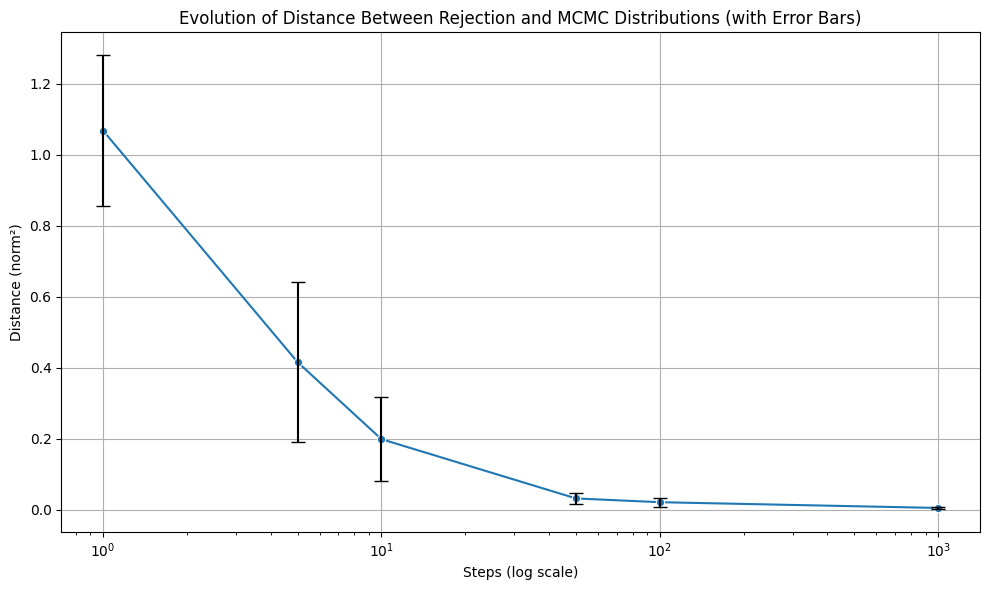

In [24]:
# Compute squared Euclidean distances and standard deviation across runs
distance_stats = []

for step in step_sizes:
    distances = []
    for run in step_results_fixed_x[step]:
        dist = sum((run[i] - rejection_mean[i]) ** 2 for i in range(len(support)))
        distances.append(dist)
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    distance_stats.append({'Steps': step, 'Distance (norm²)': mean_dist, 'Std': std_dist})

# Convert to DataFrame for plotting
distance_df = pd.DataFrame(distance_stats)

# Plot with error bars
plt.figure(figsize=(10, 6))
sns.lineplot(data=distance_df, x='Steps', y='Distance (norm²)', marker='o')
plt.errorbar(distance_df['Steps'], distance_df['Distance (norm²)'], yerr=distance_df['Std'], fmt='none', capsize=5, color='black')
plt.xscale('log')  # Use a logarithmic scale for the x-axis
plt.xlabel('Steps (log scale)')
plt.ylabel('Distance (norm²)')
plt.title('Evolution of Distance Between Rejection and MCMC Distributions (with Error Bars)')
plt.grid(True)
plt.tight_layout()
plt.show()


The norm² distance between the MCMC distributions and the target distributions decreases over time, converging towards 0 as the number of steps increases. This indicates that the MCMC algorithm effectively approximates the target distribution with sufficient iterations.

## Mixing assessment

To further assess mixing, we verify that changing the initial state (vector), doesn't impact distribution convergence

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


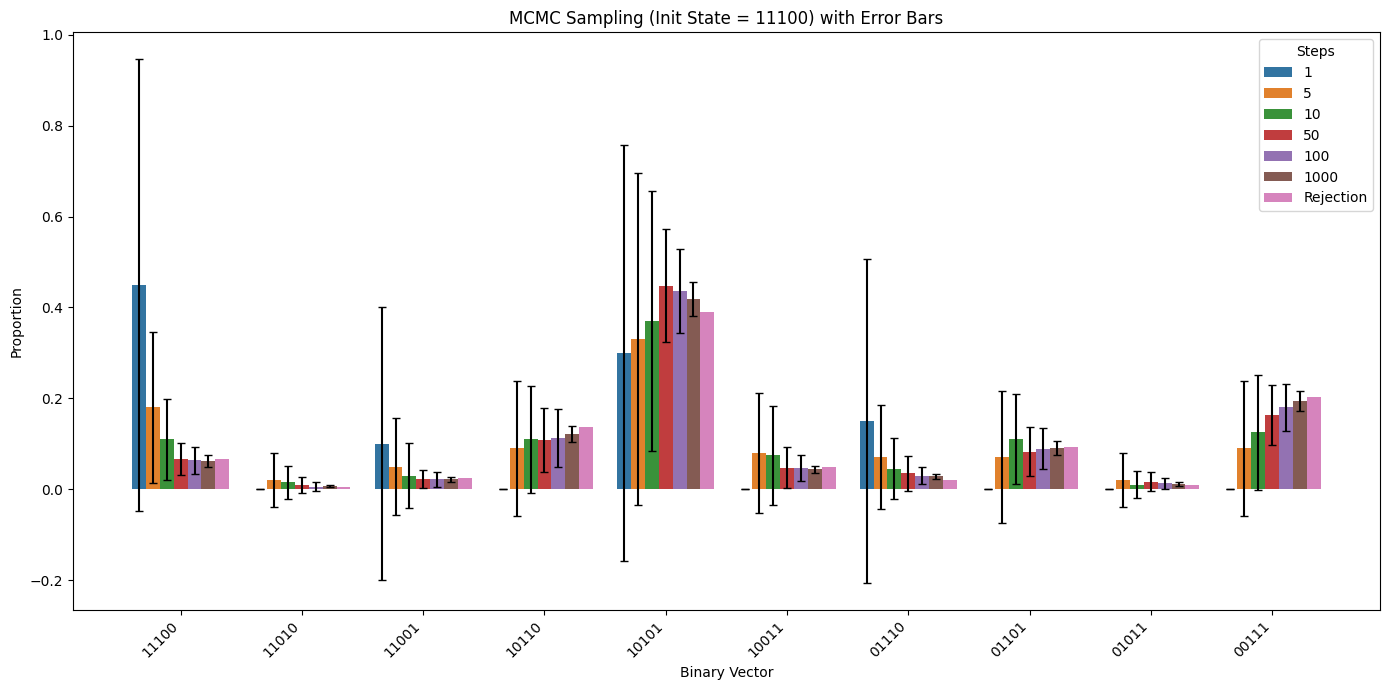

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


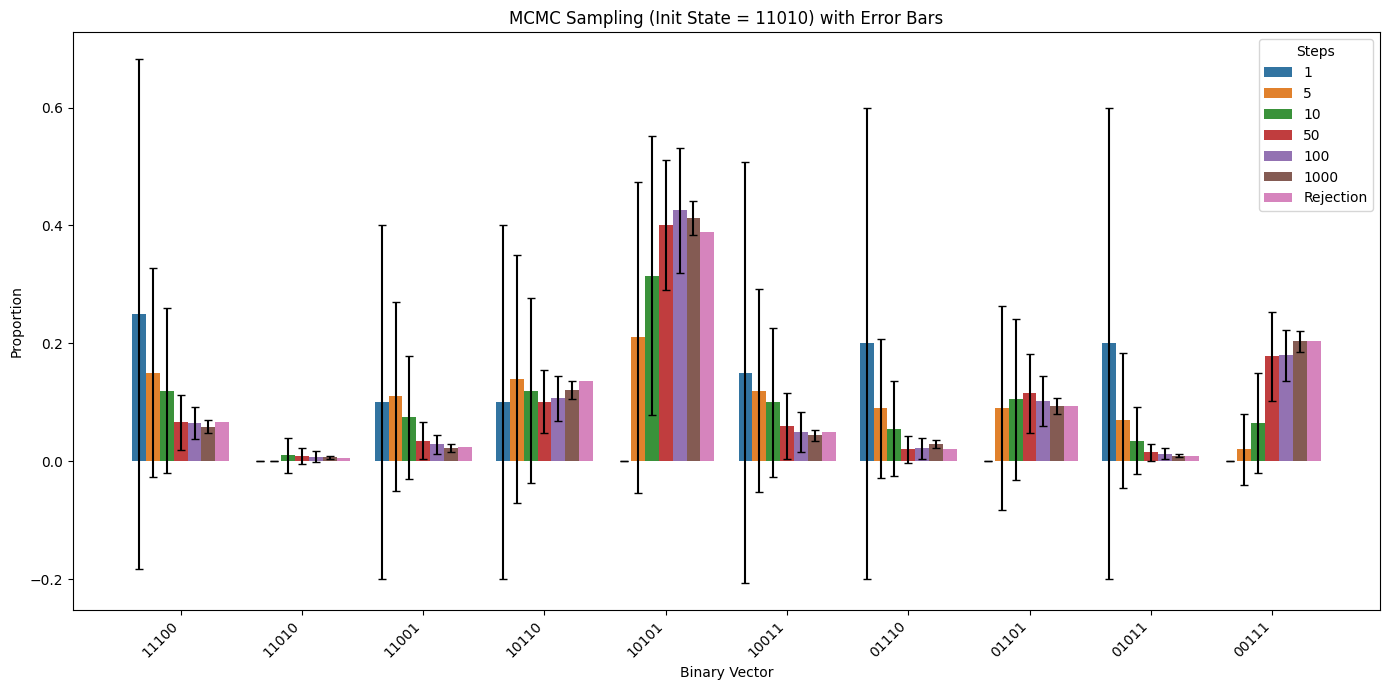

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


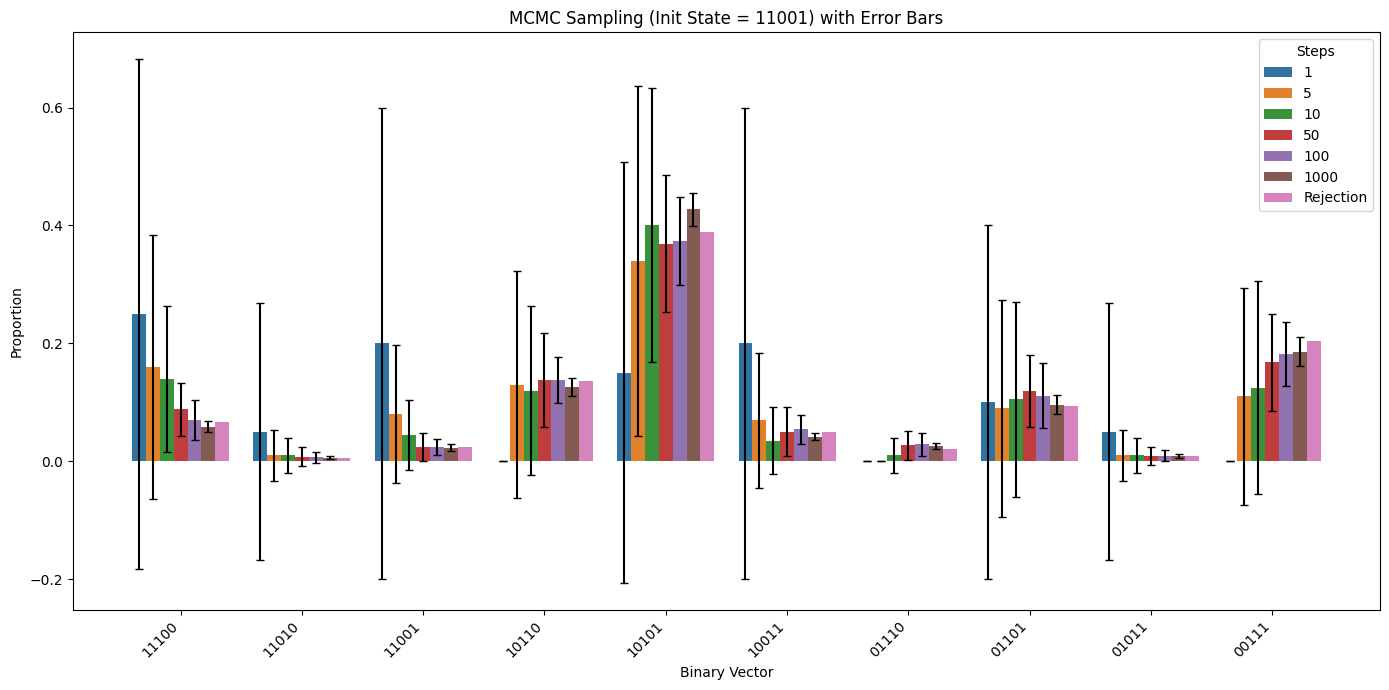

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


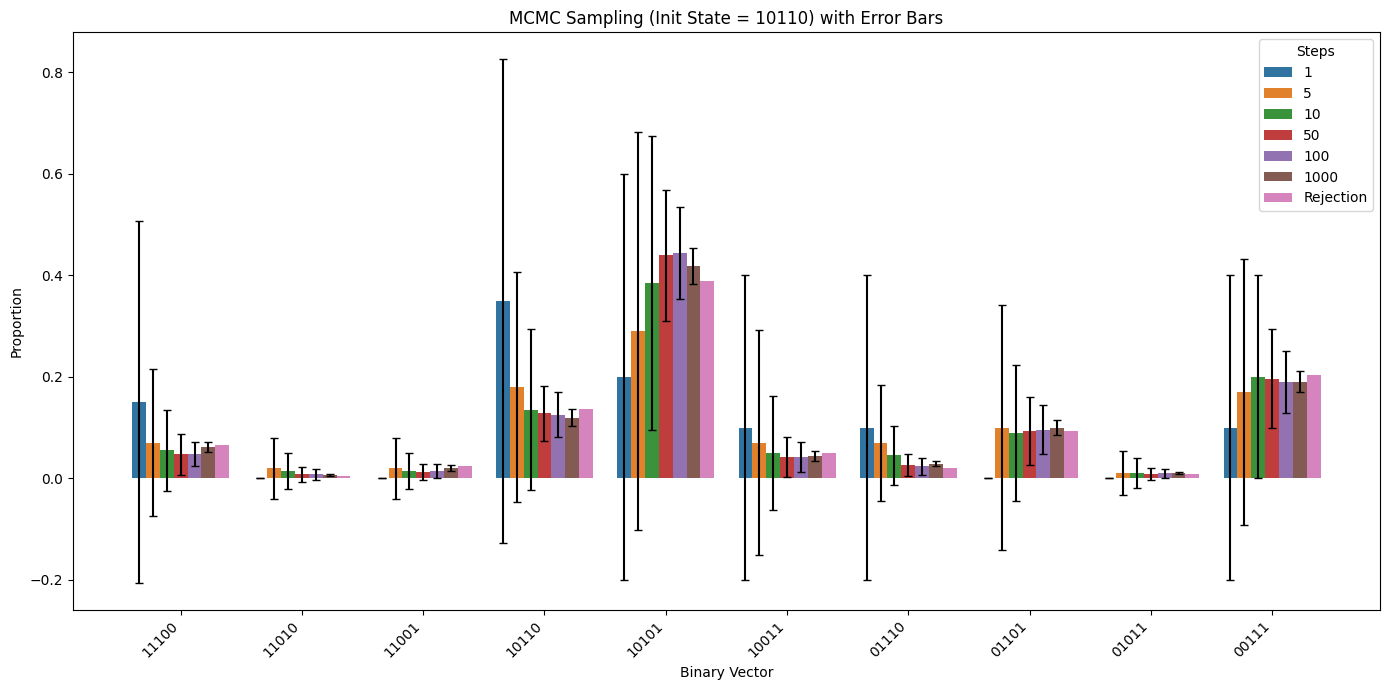

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


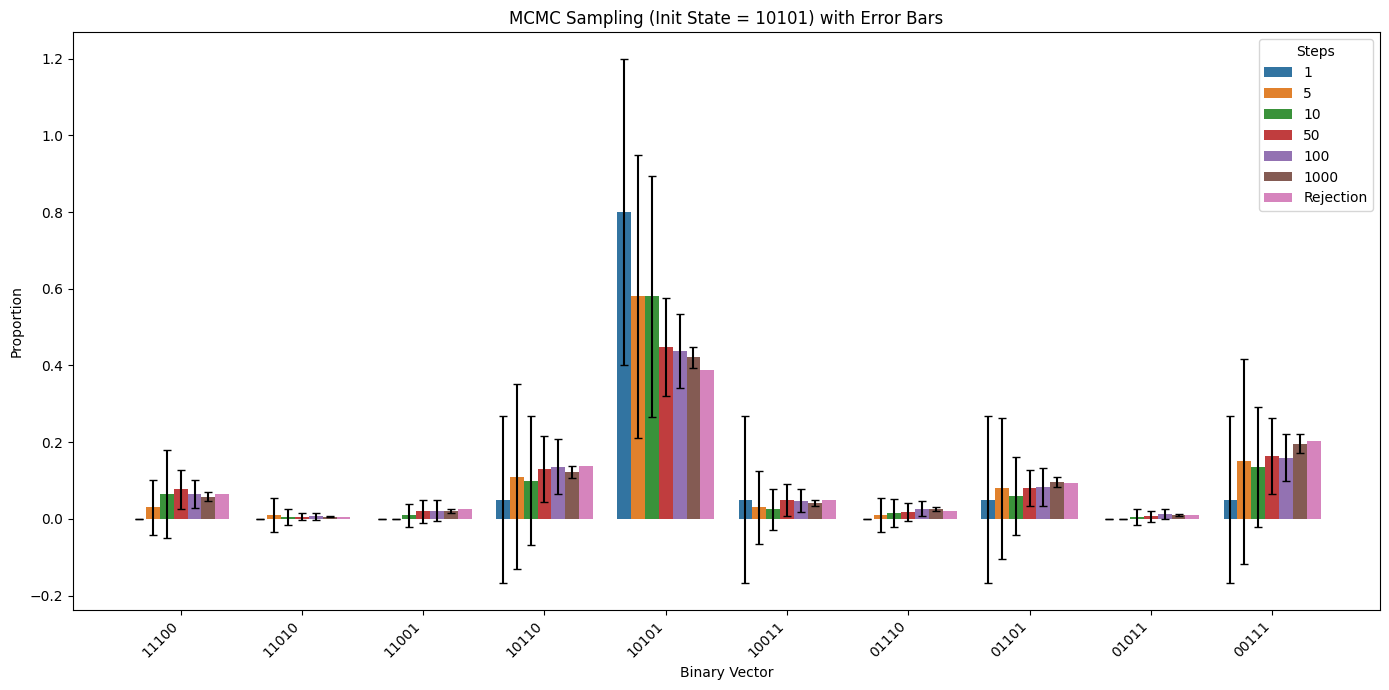

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


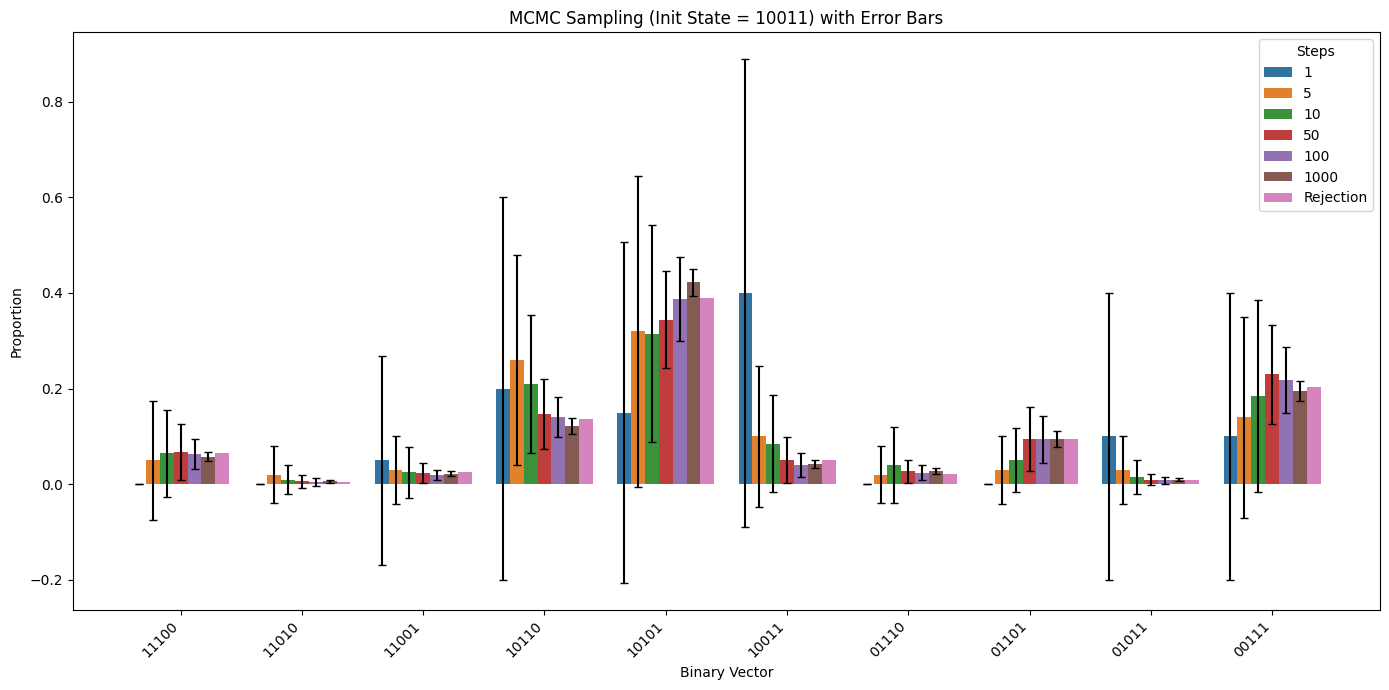

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


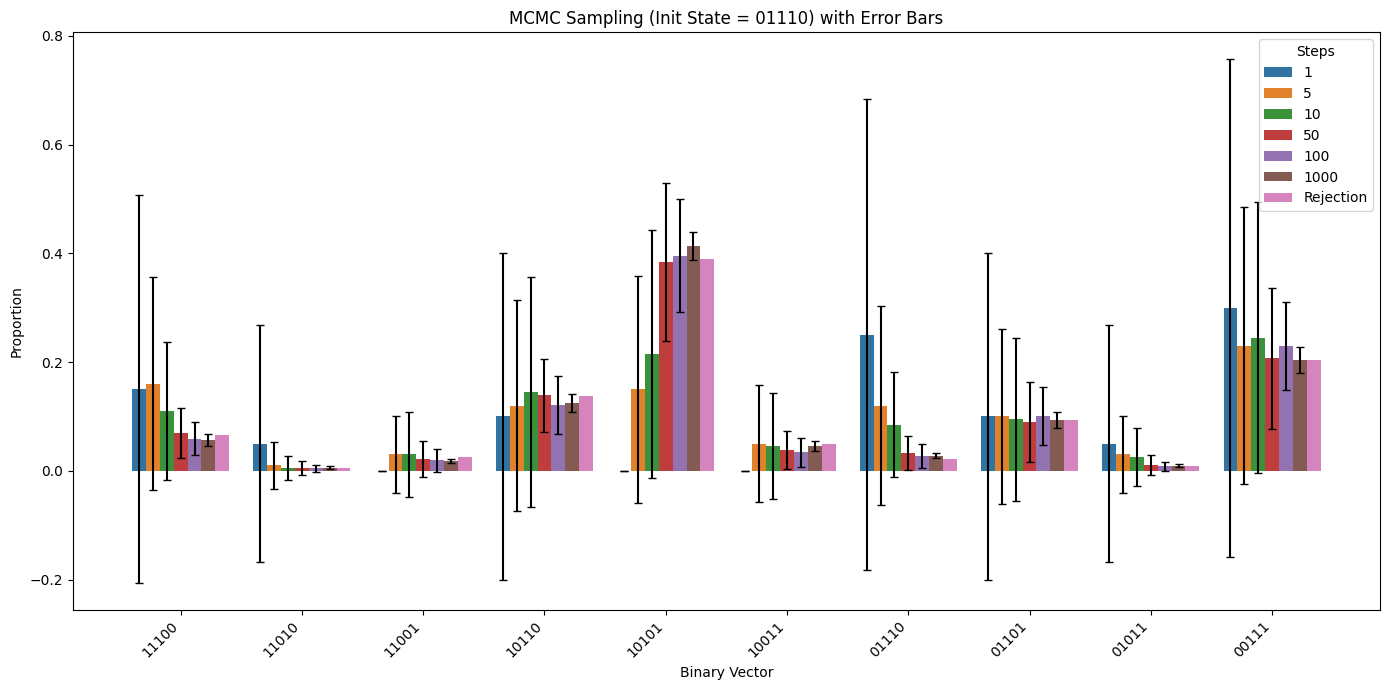

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


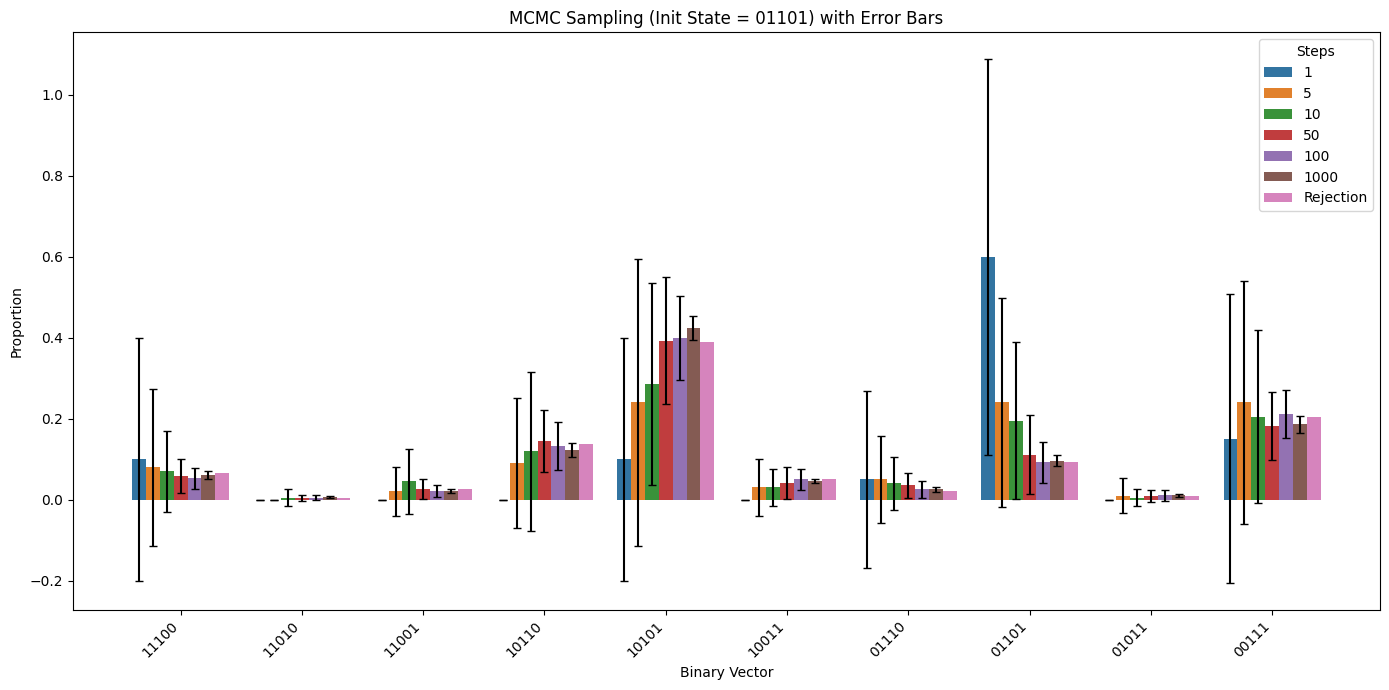

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


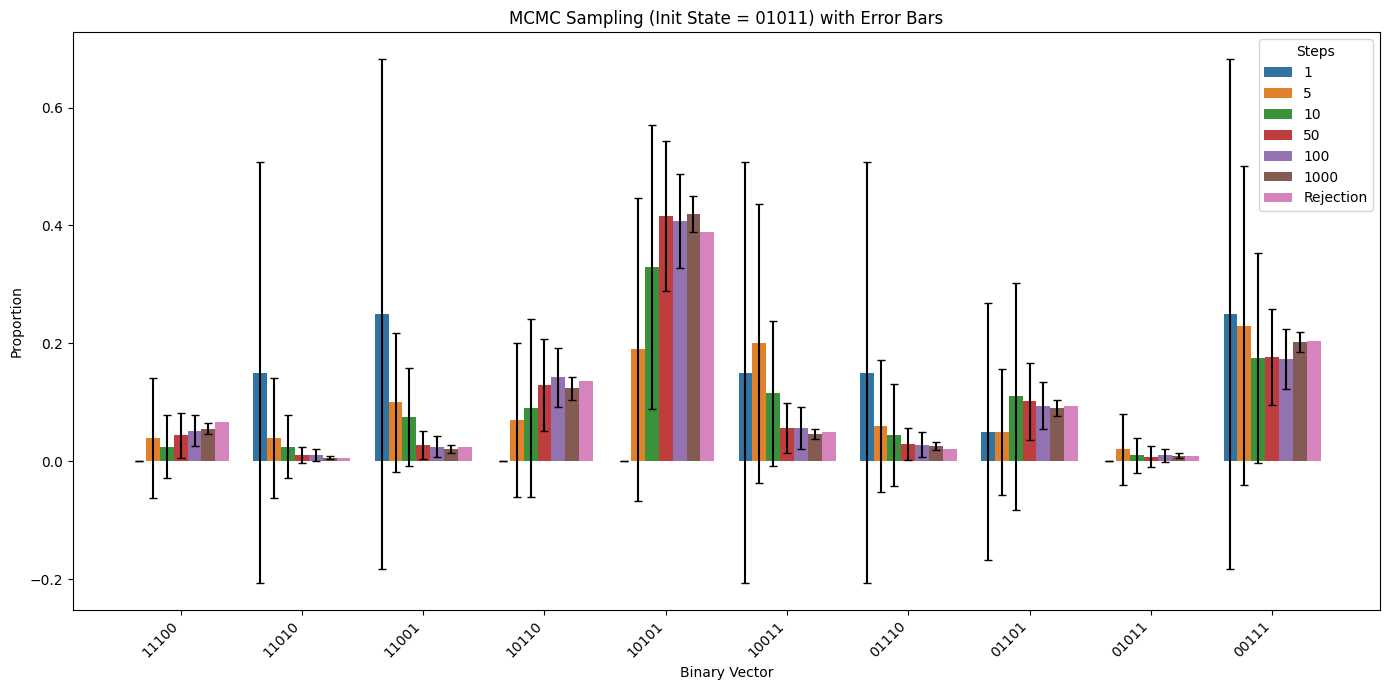

/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_80250/743684648.py:53: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)


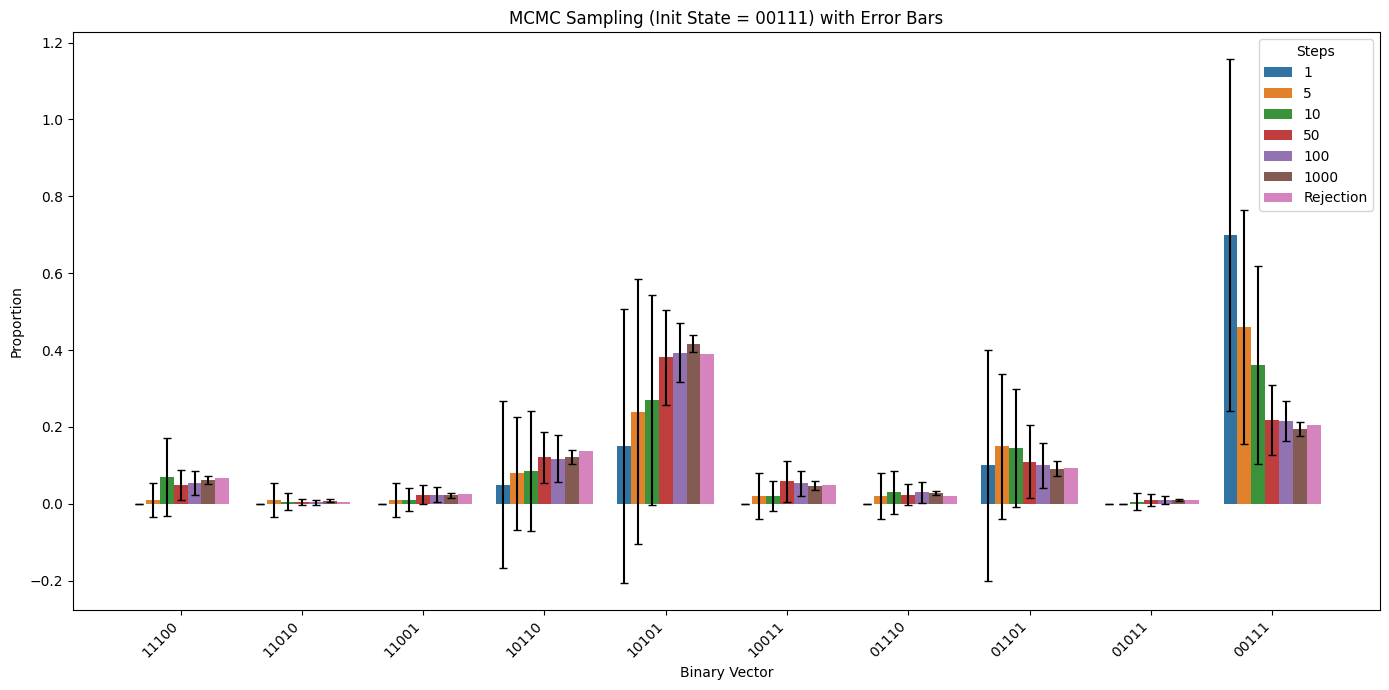

In [25]:
# Regenerate support and map each state to an index
support = [tuple(int(i in c) for i in range(5)) for c in combinations(range(5), k_fixed)]
support_indices = {vec: idx for idx, vec in enumerate(support)}

# Prepare to store 10 separate runs (one for each possible initial state)
step_results_by_init = {str(vec): {step: [] for step in step_sizes} for vec in support}

# Perform 10 runs, each starting from one of the 10 valid states
samples_per_run = 1000
n_runs_per_state = 20  # To compute std

for init_vec in support:
    for _ in range(n_runs_per_state):
        x = np.array(init_vec)
        sample_counter = Counter()
        for step in range(1, samples_per_run + 1):
            x = mcmc_step(x, w)
            sample_counter[tuple(x)] += 1
            if step in step_sizes:
                total = sum(sample_counter.values())
                proportions = [sample_counter.get(vec, 0) / total for vec in support]
                step_results_by_init[str(init_vec)][step].append(proportions)

# Plotting: one plot per initial vector
for init_vec in support:
    plot_data = []
    init_key = str(init_vec)
    for i, vec in enumerate(support):
        vec_str = ''.join(map(str, vec))
        for step in step_sizes:
            proportions = [run[i] for run in step_results_by_init[init_key][step]]
            mean = np.mean(proportions)
            std = np.std(proportions)
            plot_data.append({
                'Vector': vec_str,
                'Steps': str(step),
                'Proportion': mean,
                'Std': std
            })
        # Add rejection sampling as reference (no error)
        plot_data.append({
            'Vector': vec_str,
            'Steps': 'Rejection',
            'Proportion': rejection_mean[i],
            'Std': 0
        })

    # Create DataFrame for this init state
    df_plot = pd.DataFrame(plot_data)

    # Plot
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_plot, x='Vector', y='Proportion', hue='Steps', ci=None)

    # Add error bars manually
    step_labels = df_plot['Steps'].unique()
    x_coords = np.arange(len(support))
    bar_width = 0.8 / len(step_labels)

    for j, step in enumerate(step_labels):
        if step == 'Rejection':
            continue
        subset = df_plot[df_plot['Steps'] == step]
        offsets = x_coords - 0.4 + bar_width / 2 + j * bar_width
        plt.errorbar(offsets, subset['Proportion'], yerr=subset['Std'], fmt='none', capsize=3, color='black')

    title_str = ''.join(map(str, init_vec))
    plt.title(f'MCMC Sampling (Init State = {title_str}) with Error Bars')
    plt.xlabel('Binary Vector')
    plt.ylabel('Proportion')
    plt.legend(title='Steps')
    plt.xticks(ticks=x_coords, labels=[''.join(map(str, vec)) for vec in support], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


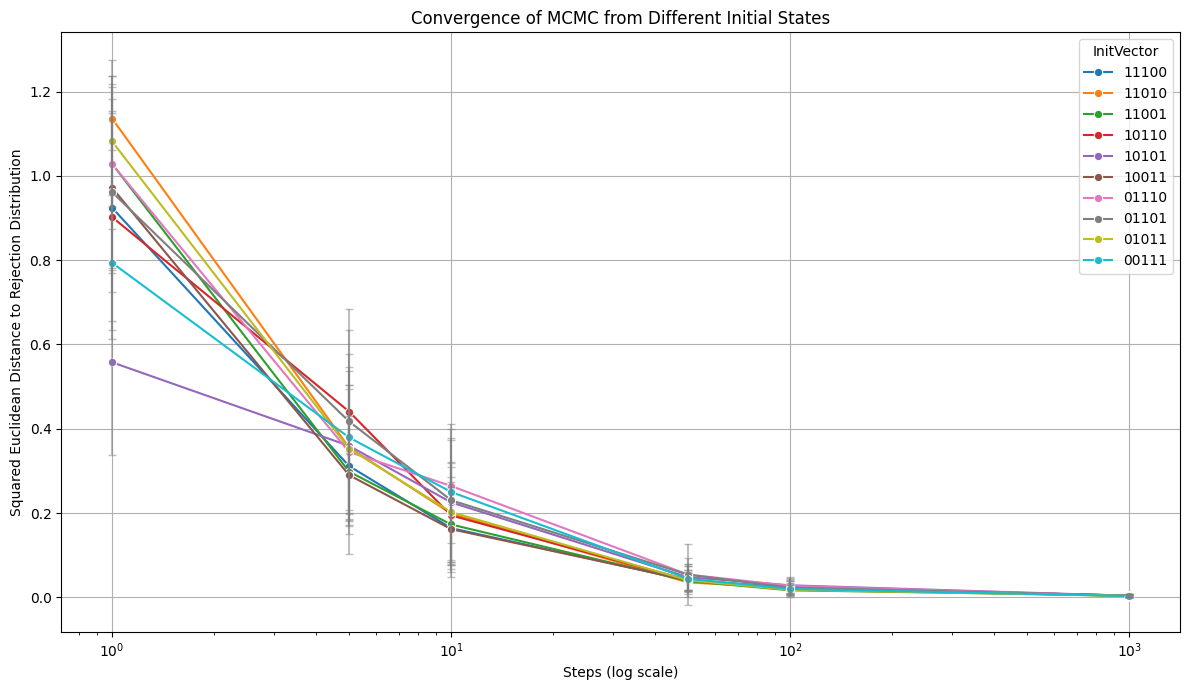

In [26]:
# Prepare distance data for plotting
distance_data_all_inits = []

for init_vec in support:
    init_key = str(init_vec)
    for step in step_sizes:
        dists = []
        for proportions in step_results_by_init[init_key][step]:
            dist = sum((proportions[i] - rejection_mean[i]) ** 2 for i in range(len(support)))
            dists.append(dist)
        distance_data_all_inits.append({
            'InitVector': ''.join(map(str, init_vec)),
            'Step': step,
            'MeanDistance': np.mean(dists),
            'StdDistance': np.std(dists)
        })

# Convert to DataFrame
df_distances = pd.DataFrame(distance_data_all_inits)

# Plot
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_distances, x='Step', y='MeanDistance', hue='InitVector', marker='o')

# Add error bars
for key, subdf in df_distances.groupby('InitVector'):
    plt.errorbar(subdf['Step'], subdf['MeanDistance'], yerr=subdf['StdDistance'],
                 fmt='none', capsize=3, label=None, color='gray', alpha=0.5)

plt.xscale('log')
plt.xlabel('Steps (log scale)')
plt.ylabel('Squared Euclidean Distance to Rejection Distribution')
plt.title('Convergence of MCMC from Different Initial States')
plt.grid(True)
plt.tight_layout()
plt.show()


## IV- RQMC
Randomized Quasi-Monte Carlo (RQMC) methods are used to improve the convergence rate of Monte Carlo simulations by reducing the variance of the estimates. Below, we compare the performance of RQMC sampling with the Dynamic Bernoulli sampling method. The comparison is based on the squared L² distance between the empirical distributions obtained from the sampling methods and the true target distribution (estimated using rejection sampling).

### RQMC Definition

In [27]:

# RQMC version    
def sample_dynamic_bernoulli_rqmc(p, I, U):
    """
    Same function as sample_dynamic_bernoulli, but using a quasi-random sequence U

    Parameters:
    - p : array-like of shape (N,)
        Success probabilities of the N independent Bernoulli variables.
    - I : int
        Target number of ones in the output (i.e., the sample is conditioned on sum(x) == I).
    - U : array-like of shape (N,)
        A vector of uniform [0, 1] values (typically from a QMC sequence like Sobol), 
        used for deterministic sampling decisions.

    Returns:
    - x : ndarray of shape (N,)
        A binary vector of 0s and 1s, sampled from the conditional distribution 
        of Bernoulli(p) vectors given sum(x) == I.
    """
    p = np.asarray(p)
    N = len(p)

    # Step 1: Compute the backward dynamic programming table q(i, n)
    # q[i, n] = probability of obtaining i ones from positions n to N
    q = np.zeros((I + 2, N + 2))  # Extra column for boundary condition
    q[0, N + 1] = 1.0  # Base case: probability of 0 ones from N+1 to N is 1

    # Fill q(0, n) for all n (no 1s left to place)
    for n in range(N, 0, -1):
        q[0, n] = (1 - p[n - 1]) * q[0, n + 1]

    # Fill rest of the table q(i, n)
    for i in range(1, I + 1):
        for n in range(N, 0, -1):
            # Either put 0 at position n (and keep i ones to place)
            q[i, n] = (1 - p[n - 1]) * q[i, n + 1]
            # Or put 1 at position n (and decrease i by 1)
            q[i, n] += p[n - 1] * q[i - 1, n + 1]

    # Step 2: Sample the vector x using conditional probabilities
    x = np.zeros(N, dtype=int)
    remaining = I  # Number of 1s left to assign

    for n in range(1, N + 1):
        if remaining == 0:
            break  # No more 1s to assign

        # Compute conditional probability of x[n-1] = 1 given remaining
        denom = q[remaining, n]
        num = p[n - 1] * q[remaining - 1, n + 1]
        r = num / denom if denom > 0 else 0  # Avoid division by zero

        # Use the quasi-random number to decide if we place a 1
        x_n = U[n - 1] < r
        x[n - 1] = x_n

        # If we placed a 1, decrease the count
        if x_n:
            remaining -= 1

    return x





### Convergence comparison with the dynamic programming bernoulli solution

  0%|          | 0/8 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
100%|██████████| 8/8 [04:39<00:00, 34.94s/it]


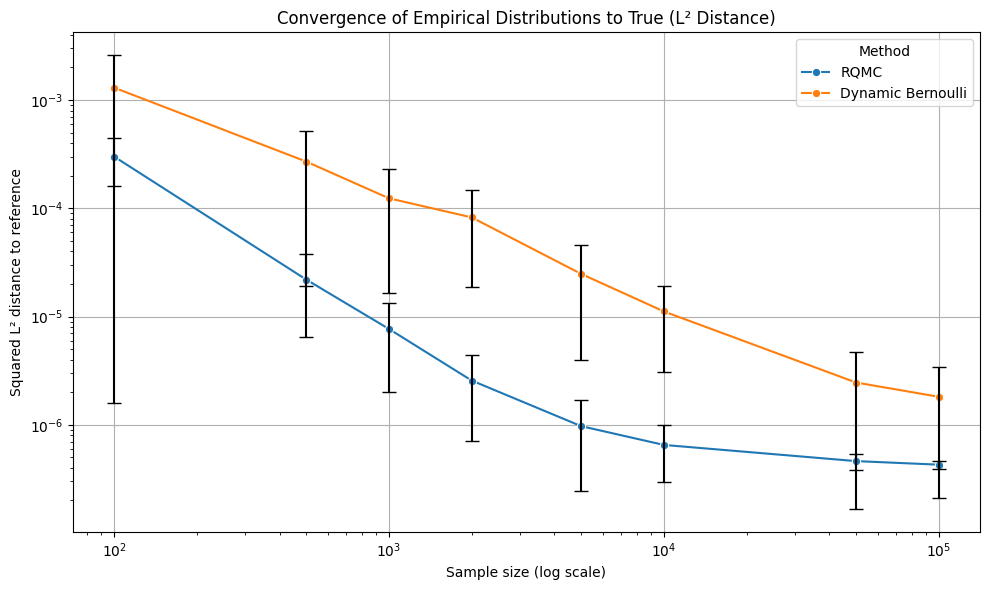

In [28]:
p_fixed = np.random.rand(5) 
k_fixed = 3
# --- Estimate true distribution using rejection sampling ---
ref_samples, _ = rejection_sampler(p_fixed, k_fixed, n_samples=500000)
ref_counts = Counter(map(tuple, ref_samples))
true_probs = np.array([ref_counts.get(vec, 0) / len(ref_samples) for vec in support])

# --- Experiment parameters ---
n_runs = 50
sample_sizes = [100, 500, 1000, 2000, 5000, 10000, 50000, 100000]

# --- Collect distance stats ---
distance_stats_rqmc = []
distance_stats_dyn = []

for samples_per_run in tqdm(sample_sizes):
    distances_rqmc = []
    distances_dyn = []
    
    for _ in range(n_runs):
        # --- RQMC Sampling ---
        sampler = qmc.Sobol(d=len(p_fixed), scramble=True)
        rqmc_values = sampler.random(samples_per_run)
        rqmc_samples = [tuple(sample_dynamic_bernoulli_rqmc(p_fixed, k_fixed, U)) for U in rqmc_values]
        rqmc_counts = Counter(rqmc_samples)
        rqmc_freqs = np.array([rqmc_counts.get(vec, 0) / samples_per_run for vec in support])
        dist_rqmc = np.sum((rqmc_freqs - true_probs) ** 2)
        distances_rqmc.append(dist_rqmc)

        # --- Dynamic Bernoulli Sampling ---
        dyn_samples = [tuple(sample_dynamic_bernoulli(p_fixed, k_fixed)) for _ in range(samples_per_run)]
        dyn_counts = Counter(dyn_samples)
        dyn_freqs = np.array([dyn_counts.get(vec, 0) / samples_per_run for vec in support])
        dist_dyn = np.sum((dyn_freqs - true_probs) ** 2)
        distances_dyn.append(dist_dyn)

    # Store results
    distance_stats_rqmc.append({
        "Samples": samples_per_run,
        "Mean Distance²": np.mean(distances_rqmc),
        "Std": np.std(distances_rqmc),
        "Method": "RQMC"
    })
    distance_stats_dyn.append({
        "Samples": samples_per_run,
        "Mean Distance²": np.mean(distances_dyn),
        "Std": np.std(distances_dyn),
        "Method": "Dynamic Bernoulli"
    })

# --- Combine results and plot ---
df_distances = pd.DataFrame(distance_stats_rqmc + distance_stats_dyn)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_distances, x="Samples", y="Mean Distance²", hue="Method", marker='o')
for method in df_distances["Method"].unique():
    subset = df_distances[df_distances["Method"] == method]
    plt.errorbar(subset["Samples"], subset["Mean Distance²"], yerr=subset["Std"], fmt='none', capsize=5, color='black')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sample size (log scale)")
plt.ylabel("Squared L² distance to reference")
plt.title("Convergence of Empirical Distributions to True (L² Distance)")
plt.grid(True)
plt.tight_layout()
plt.show()

The results demonstrate that Randomized Quasi-Monte Carlo (RQMC) sampling achieves faster convergence compared to the Dynamic Bernoulli sampling method. 